In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

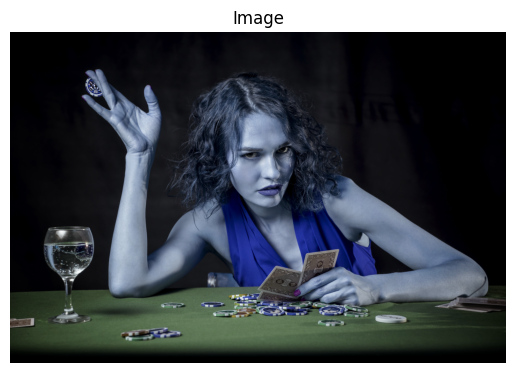

In [30]:
#image=cv2.imread(r"D:\remoote\zyz.jpg")
image=cv2.imread("1096155.jpg")
plt.imshow(image)
plt.axis("off")
plt.title("Image")
plt.show()

In [31]:
image.shape

(4016, 6016, 3)

In [32]:
def sliding_window(image,step_size,window_size):
    # let's slide the window acrosss the image
    for y in range(0,image.shape[0]-window_size[1]+1,step_size):
        for x in range(0,image.shape[1]-window_size[0]+1,step_size):
            yield (x,y,image[y:y +window_size[1],x:x+window_size[0]])

    

In [33]:
window_size=(500,500)
window_size = np.array(window_size)
step_size=216



In [34]:
# for (x, y, window) in sliding_window(image=image, step_size=step_size, window_size=window_size):
#     if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
#         continue

#     clone = image.copy()
#     cv2.rectangle(clone, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)

#     cv2.imshow("Window", cv2.cvtColor(clone, cv2.COLOR_RGB2BGR))
#     cv2.waitKey()
#     cv2.destroyAllWindows()


In [35]:
#Initialize HOG Descriptor and SVM Classifier:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())


In [36]:
(rects, weights) = hog.detectMultiScale(image, winStride=(8, 8),
                                        padding=(16, 16), scale=1.05)


In [37]:
#Apply Non-Maximum Suppression:
from imutils.object_detection import non_max_suppression

rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
picks = non_max_suppression(rects, probs=None, overlapThresh=0.65)


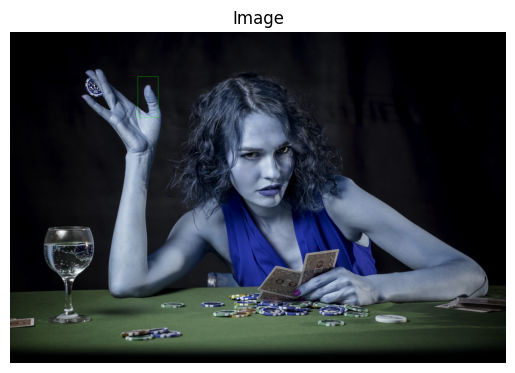

In [38]:
#Draw Bounding Boxes:
for (xA, yA, xB, yB) in picks:
    cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

plt.imshow(image)
plt.axis("off")
plt.title("Image")
plt.show()


In [39]:
#Deep Learning Approach for Object Detection (e.g., Faster R-CNN, YOLO, SSD)

In [40]:
config_path = r'D:\MINE\Python\Yolo v3\yolov3 (2).cfg'
weights_path = r'D:\MINE\Python\Yolo v3\yolov3.weights'
names_path = r'D:\MINE\Python\Yolo v3\coco.names'

In [41]:
net = cv2.dnn.readNet(weights_path, config_path)

In [42]:
with open(names_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

In [43]:

height, width = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

In [44]:
# Get the output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


In [45]:
# Perform the forward pass
detections = net.forward(output_layers)

In [46]:
# Process the detections
boxes = []
confidences = []
class_ids = []

In [47]:
for detection in detections:
    for obj in detection:
        scores = obj[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(obj[0] * width)
            center_y = int(obj[1] * height)
            w = int(obj[2] * width)
            h = int(obj[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


In [48]:
# Apply non-max suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)


In [49]:
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

In [50]:
# cv2.imshow("Detections", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

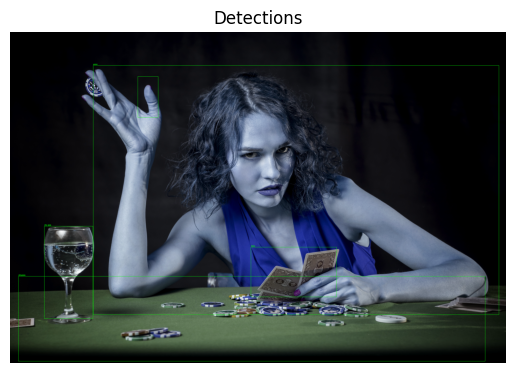

In [51]:
plt.imshow(image)
plt.axis("off")
plt.title("Detections")
plt.show()





In [12]:
import tensorflow as tf

def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.
    
    Parameters:
    box1: Tensor of shape (4,) containing [x1, y1, x2, y2] for the first box
    box2: Tensor of shape (4,) containing [x1, y1, x2, y2] for the second box
    
    Returns:
    iou: Tensor containing the IoU value
    """
    # Calculate the coordinates of the intersection rectangle
    x1 = tf.maximum(box1[0], box2[0])
    y1 = tf.maximum(box1[1], box2[1])
    x2 = tf.minimum(box1[2], box2[2])
    y2 = tf.minimum(box1[3], box2[3])

    # Calculate the area of the intersection rectangle
    intersection_area = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the area of the union
    union_area = box1_area + box2_area - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area
    return iou

# Example usage
box1 = tf.constant([50, 50, 200, 200], dtype=tf.float32)
box2 = tf.constant([100, 100, 250, 250], dtype=tf.float32)
iou = compute_iou(box1, box2)
print("IoU:", iou.numpy())


IoU: 0.2857143


In [13]:
import numpy as np

def calculate_iou(box1, box2):
    # Extract coordinates
    x1_gt, y1_gt, x2_gt, y2_gt = box1
    x1_p, y1_p, x2_p, y2_p = box2
    
    # Calculate intersection coordinates
    x1_i = max(x1_gt, x1_p)
    y1_i = max(y1_gt, y1_p)
    x2_i = min(x2_gt, x2_p)
    y2_i = min(y2_gt, y2_p)
    
    # Calculate intersection area
    intersection_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)
    
    # Calculate areas of the bounding boxes
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    p_area = (x2_p - x1_p) * (y2_p - y1_p)
    
    # Calculate union area
    union_area = gt_area + p_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area
    
    return iou

# Example usage
box1 = tf.constant([50, 50, 200, 200], dtype=tf.float32)
box2 = tf.constant([100, 100, 250, 250], dtype=tf.float32)
  # Predicted bounding box

iou = calculate_iou(box1, box2)
print(f"IoU: {iou}")


IoU: 0.2857142984867096


In [18]:
import tensorflow as tf

def non_max_suppression(boxes, scores, iou_threshold):
    """
    Apply Non-Maximum Suppression (NMS) to avoid detecting too many
    overlapping bounding boxes for a given object.

    Parameters:
    boxes: Tensor of shape (N, 4) containing N bounding boxes
    scores: Tensor of shape (N,) containing the scores for each box
    iou_threshold: Float representing the threshold for IoU to consider for suppression

    Returns:
    selected_indices: Indices of the selected boxes after applying NMS
    """
    selected_indices = tf.image.non_max_suppression(
        boxes, scores, max_output_size=100, iou_threshold=iou_threshold
    )
    return selected_indices

# Example usage
boxes = tf.constant([
    [50, 50, 200, 200],
    [60, 60, 210, 210],
    [300, 300, 400, 400]
], dtype=tf.float32)

scores = tf.constant([0.9, 0.75, 0.6], dtype=tf.float32)
iou_threshold = 0.5

selected_indices = non_max_suppression(boxes, scores, iou_threshold)
selected_boxes = tf.gather(boxes, selected_indices)
selected_scores = tf.gather(scores, selected_indices)

print("Selected boxes:", selected_boxes.numpy())
print("Selected scores:", selected_scores.numpy())


Selected boxes: [[ 50.  50. 200. 200.]
 [300. 300. 400. 400.]]
Selected scores: [0.9 0.6]


In [21]:
import numpy as np

def iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.
    
    Parameters:
    box1: numpy array of shape (4,) containing [x1, y1, x2, y2]
    box2: numpy array of shape (4,) containing [x1, y1, x2, y2]
    
    Returns:
    iou: float representing the IoU
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area

def non_max_suppression(boxes, scores, iou_threshold):
    """
    Apply Non-Maximum Suppression (NMS) to avoid detecting too many
    overlapping bounding boxes for a given object.
    
    Parameters:
    boxes: numpy array of shape (N, 4) containing N bounding boxes
    scores: numpy array of shape (N,) containing the scores for each box
    iou_threshold: float representing the threshold for IoU to consider for suppression
    
    Returns:
    selected_indices: list of indices of the selected boxes after applying NMS
    """
    indices = np.argsort(scores)[::-1]
    selected_indices = []

    while len(indices) > 0:
        current = indices[0]
        selected_indices.append(current)
        remaining_indices = indices[1:]

        filtered_indices = []
        for idx in remaining_indices:
            if iou(boxes[current], boxes[idx]) < iou_threshold:
                filtered_indices.append(idx)
        
        indices = np.array(filtered_indices)

    return selected_indices

# Example usage
boxes = np.array([
    [50, 50, 200, 200],
    [60, 60, 210, 210],
    [300, 300, 400, 400]
], dtype=np.float32)

scores = np.array([0.9, 0.75, 0.6], dtype=np.float32)
iou_threshold = 0.5

selected_indices = non_max_suppression(boxes, scores, iou_threshold)
selected_boxes = boxes[selected_indices]
selected_scores = scores[selected_indices]

print("Selected boxes:", selected_boxes)
print("Selected scores:", selected_scores)


Selected boxes: [[ 50.  50. 200. 200.]
 [300. 300. 400. 400.]]
Selected scores: [0.9 0.6]


In [24]:
import numpy as np

def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    
    return intersection_area / union_area

def non_max_suppression(boxes, scores, iou_threshold):
    indices = np.argsort(scores)[::-1]
    selected_indices = []

    while len(indices) > 0:
        current = indices[0]
        selected_indices.append(current)
        remaining_indices = indices[1:]

        filtered_indices = []
        for idx in remaining_indices:
            if iou(boxes[current], boxes[idx]) < iou_threshold:
                filtered_indices.append(idx)
        
        indices = np.array(filtered_indices)

    return selected_indices

def calculate_ap(precision, recall):
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap

def calculate_map(predicted_boxes, predicted_scores, ground_truth_boxes, iou_threshold=0.5):
    ious = np.zeros((len(predicted_boxes), len(ground_truth_boxes)))
    for i, pred_box in enumerate(predicted_boxes):
        for j, gt_box in enumerate(ground_truth_boxes):
            ious[i, j] = iou(pred_box, gt_box)
    
    true_positives = np.zeros(len(predicted_boxes))
    false_positives = np.zeros(len(predicted_boxes))
    gt_detected = np.zeros(len(ground_truth_boxes))
    
    for i, pred_box in enumerate(predicted_boxes):
        max_iou = np.max(ious[i])
        max_iou_idx = np.argmax(ious[i])
        
        if max_iou >= iou_threshold and not gt_detected[max_iou_idx]:
            true_positives[i] = 1
            gt_detected[max_iou_idx] = 1
        else:
            false_positives[i] = 1
    
    cumulative_tp = np.cumsum(true_positives)
    cumulative_fp = np.cumsum(false_positives)

    precision = cumulative_tp / (cumulative_tp + cumulative_fp)
    recall = cumulative_tp / len(ground_truth_boxes)

    ap = calculate_ap(precision, recall)
    return ap

# Example usage for a single class
predicted_boxes = np.array([
    [50, 50, 200, 200],
    [60, 60, 210, 210],
    [300, 300, 400, 400]
], dtype=np.float32)

predicted_scores = np.array([0.9, 0.75, 0.6], dtype=np.float32)
ground_truth_boxes = np.array([
    [55, 55, 195, 195],
    [300, 300, 400, 400]
], dtype=np.float32)

ap = calculate_map(predicted_boxes, predicted_scores, ground_truth_boxes, iou_threshold=0.5)
print("Average Precision (AP):", ap)


# Example for multiple classes
predicted_boxes_class1 = np.array([[50, 50, 200, 200], [60, 60, 210, 210], [300, 300, 400, 400]], dtype=np.float32)
predicted_scores_class1 = np.array([0.9, 0.75, 0.6], dtype=np.float32)
ground_truth_boxes_class1 = np.array([[55, 55, 195, 195], [300, 300, 400, 400]], dtype=np.float32)

predicted_boxes_class2 = np.array([[30, 30, 180, 180], [40, 40, 190, 190]], dtype=np.float32)
predicted_scores_class2 = np.array([0.85, 0.65], dtype=np.float32)
ground_truth_boxes_class2 = np.array([[35, 35, 175, 175]], dtype=np.float32)

ap_class1 = calculate_map(predicted_boxes_class1, predicted_scores_class1, ground_truth_boxes_class1, iou_threshold=0.5)
ap_class2 = calculate_map(predicted_boxes_class2, predicted_scores_class2, ground_truth_boxes_class2, iou_threshold=0.5)

mean_ap = np.mean([ap_class1, ap_class2])
print("Mean Average Precision (mAP):", mean_ap)



Average Precision (AP): 0.8333333333333333
Mean Average Precision (mAP): 0.9166666666666666


In [34]:
import os
import xml.etree.ElementTree as ET

def convert_voc_to_yolo(voc_dir, yolo_dir, classes):
    if not os.path.exists(yolo_dir):
        os.makedirs(yolo_dir)
    
    for filename in os.listdir(voc_dir):
        if not filename.endswith('.xml'):
            continue
        
        tree = ET.parse(os.path.join(voc_dir, filename))
        root = tree.getroot()
        
        image_id = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        yolo_annotations = []
        
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult) == 1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymin').text), int(xmlbox.find('ymax').text))
            yolo_box = (b[0] + b[1]) / 2.0 / width, (b[2] + b[3]) / 2.0 / height, (b[1] - b[0]) / width, (b[3] - b[2]) / height
            yolo_annotations.append(f"{cls_id} {' '.join(map(str, yolo_box))}")
        
        with open(os.path.join(yolo_dir, f"{os.path.splitext(image_id)[0]}.txt"), 'w') as f:
            f.write('\n'.join(yolo_annotations))

voc_dir = "VOCdevkit/VOC2007/Annotations"
yolo_dir = "YOLO/Annotations"
classes = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
convert_voc_to_yolo(voc_dir, yolo_dir, classes)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'VOCdevkit/VOC2007/Annotations'